In [4]:
import folium
import pandas as pd
from folium.plugins import TimestampedGeoJson
from shapely.geometry import Point
import numpy as np

from branca.colormap import linear




In [5]:
data = pd.read_csv("station_agg.csv")
df = pd.DataFrame(data)

In [6]:
print(data.head())  # Voir les premières lignes du dataset
print(data.describe())  # Statistiques descriptives pour détecter les anomalies
print(data['moyenne_occup'].value_counts())  # Fréquences des valeurs spécifiques


                   timestamp carre_id  moyenne_occup  count_occup     lati  \
0  2020-01-01 00:00:00+00:00    10_17       0.666667            1  48.8625   
1  2020-01-01 00:00:00+00:00    10_20       0.000000            1  48.8625   
2  2020-01-01 00:00:00+00:00    10_28       0.916667            1  48.8625   
3  2020-01-01 00:00:00+00:00     10_3       0.666667            1  48.8625   
4  2020-01-01 00:00:00+00:00     10_5       0.333333            1  48.8625   

     long  
0  2.3425  
1  2.3575  
2  2.3975  
3  2.2725  
4  2.2825  
       moyenne_occup   count_occup          lati          long
count   10985.000000  10985.000000  10985.000000  10985.000000
mean        0.280811      1.030769     48.857654      2.336731
std         0.263807      0.172700      0.019296      0.040320
min         0.000000      1.000000     48.822500      2.257500
25%         0.000000      1.000000     48.847500      2.307500
50%         0.250000      1.000000     48.857500      2.337500
75%         0.5000

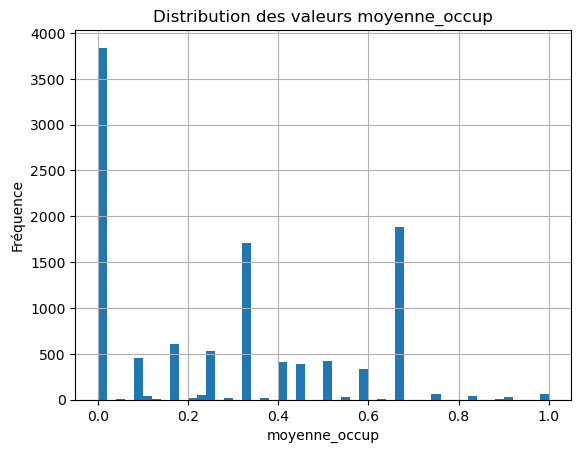

In [7]:
import matplotlib.pyplot as plt

data['moyenne_occup'].hist(bins=50)
plt.title("Distribution des valeurs moyenne_occup")
plt.xlabel("moyenne_occup")
plt.ylabel("Fréquence")
plt.show()


In [10]:
import folium
import pandas as pd
from folium.plugins import TimestampedGeoJson
from branca.colormap import linear

# Charger les données à partir du fichier CSV
file_path = 'station_agg.csv'  # Remplacez par le chemin du fichier
data = pd.read_csv(file_path, parse_dates=['timestamp'])

# Préparer les coins des carrés à partir des centres
square_size = 0.005  # Taille des carrés (latitude/longitude)
data['lat_min'] = data['lati'] - square_size / 2
data['lat_max'] = data['lati'] + square_size / 2
data['lon_min'] = data['long'] - square_size / 2
data['lon_max'] = data['long'] + square_size / 2

# Préparer la colormap
cmap = linear.PuRd_09.scale(data['moyenne_occup'].min(), data['moyenne_occup'].max())

# Initialiser la carte centrée sur Paris
m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Préparer le GeoJSON pour animer les carrés
geojson_data = []

for _, row in data.iterrows():
    # Définir la couleur du carré en fonction de 'moyenne_k'
    color = cmap(row['moyenne_occup'])

    # Ajouter le carré à la liste GeoJSON
    geojson_data.append({
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [row['lon_min'], row['lat_min']],
                [row['lon_min'], row['lat_max']],
                [row['lon_max'], row['lat_max']],
                [row['lon_max'], row['lat_min']],
                [row['lon_min'], row['lat_min']]  # Fermer le polygone
            ]]
        },
        "properties": {
            "time": row['timestamp'].isoformat(),
            "style": {
                "color": "",
                "fillColor": color,
                "fillOpacity": 0.7,
            },
            "popup": (f"Carré ID: {row['carre_id']}<br>"
                      f"Heure: {row['timestamp']}<br>"
                      f"Moyenne Occup: {row['moyenne_occup']:.2f}<br>"
                      f"Count Occup: {row['count_occup']}")
        }
    })

# Ajouter l'animation des carrés sur la carte
TimestampedGeoJson(
    {"type": "FeatureCollection", "features": geojson_data},
    period='PT1H',  # Intervalle entre les changements (1 heure)
    duration="PT1H",  # Durée d'affichage de chaque état
    auto_play=True,   # Lancer automatiquement
    loop=False,       # Ne pas boucler
    add_last_point=True
).add_to(m)

# Afficher la carte
m
